# 1.1 - Example of an KM plot

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
from matplotlib import patches
import lifelines

In [2]:
GENESET = "Hallmarks"

logrank_test = pd.read_csv(f"../data/{GENESET}/logrank-scores-test-statistic.tsv", sep="\t", index_col=[0]).fillna(0)
logrank_pval = pd.read_csv(f"../data/{GENESET}/logrank-scores-p-value.tsv", sep="\t", index_col=[0]).fillna(1)
rmst_scores = pd.read_csv(f"../data/{GENESET}/rmst-difference-scores.tsv", sep="\t", index_col=[0]).fillna(0)

In [3]:
tcga_grouped = {}

for tcga in logrank_pval.columns:
    x = pd.concat((
        pd.Series(ss.false_discovery_control(logrank_pval[tcga].values), index=logrank_pval.index),
        logrank_test[tcga],
        np.abs(rmst_scores[tcga])
    ), axis=1)
    x.columns = ["p-value", "logrank", "rmst"]

    tcga_grouped[tcga] = x

## KM plot with Lifelines

In [14]:
TIME_LIMIT_PERCENTILE = 75

def plot_KM(TCGA, HALLMARK, ax):
    survival_data = pd.read_csv(f"../tcga-data/data/raw/TCGA-{TCGA}-survival.csv", sep=",", index_col=[0]).dropna()
    ssgsea_data = pd.read_csv(f"../data/{GENESET}/TCGA-{TCGA}-ssGSEA.tsv", sep="\t", index_col=[0])

    common_ids = list(set(survival_data.index.values).intersection(ssgsea_data.index.values))
    survival_data = survival_data.loc[common_ids]
    ssgsea_data = ssgsea_data.loc[common_ids]

    time_limit_75 = np.percentile(survival_data["time"].values, TIME_LIMIT_PERCENTILE)

    ch1 = ssgsea_data[ssgsea_data[HALLMARK] > ssgsea_data[HALLMARK].median()].index
    kmf = lifelines.KaplanMeierFitter()
    kmf.fit(survival_data.loc[ch1, "time"], survival_data.loc[ch1, "event"])

    kmf2 = lifelines.KaplanMeierFitter()
    kmf2.fit(survival_data.loc[~survival_data.index.isin(ch1), "time"], survival_data.loc[~survival_data.index.isin(ch1), "event"])

    #kmf_overall = lifelines.KaplanMeierFitter()
    #kmf_overall.fit(survival_data["time"], survival_data["event"])

    kmf.plot(ax=ax, label="Enriched", color="red", ci_alpha=0.1) #, at_risk_counts=True)
    kmf2.plot(ax=ax, label="Non-enriched", color="k", ci_alpha=0.1)
    #kmf_overall.plot(ax=ax, label="", color="white", alpha=0.0, ci_alpha=0.0, zorder=0, at_risk_counts=True)

    ax.legend(frameon=False, fontsize=12)
    ax.plot([time_limit_75, time_limit_75], [0, 1], ls="--", color="gray")
    ax.text(time_limit_75, 1, " 75%", verticalalignment="top")

    ax.text(0, 0, f"{TCGA} // {HALLMARK if len(HALLMARK) < 35 else 'EMT'}", fontsize=10, verticalalignment="top")
    ax.set_ylim(bottom=-0.1)

    for loc in ["top", "right"]:
        ax.spines[loc].set_visible(False)
    return kmf, kmf2, time_limit_75

LGG $p$ = 3.0e-07
SKCM $p$ = 1.5e-06


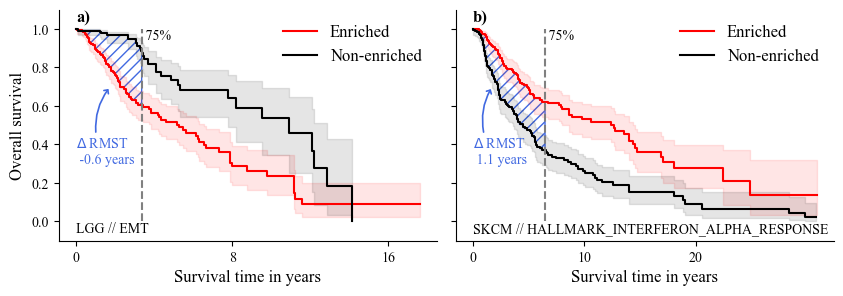

In [15]:
TCGA_1 = "LGG"
HALLMARK_1 = "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"

TCGA_2 = "SKCM"
HALLMARK_2 = "HALLMARK_INTERFERON_ALPHA_RESPONSE"

plt.rcParams["font.family"] = "Times New Roman"

f, ax = plt.subplots(1,2, figsize=(10,3), sharey=True, gridspec_kw={"wspace":0.05})

c1 = plot_KM(TCGA_1, HALLMARK_1, ax[0])
c2 = plot_KM(TCGA_2, HALLMARK_2, ax[1])

for i, letter in enumerate(list("ab")):
    ax[i].set_ylim(top=1.1)
    ax[i].text(0, 1.02, f"{letter})", fontsize=12, weight="bold",
                verticalalignment="bottom")
    
for i, c in enumerate([c1, c2]):
    joined_km = pd.concat((c[0].survival_function_, c[1].survival_function_), axis=1, join="outer").sort_index()
    joined_km.columns = ["curve1", "curve2"]
    joined_km.interpolate("pad", inplace=True)
    joined_km = joined_km.loc[:c[2]]

    ax[i].fill_between(
        joined_km.index.values, joined_km["curve1"].values, joined_km["curve2"].values,
        edgecolors="royalblue", zorder=0, hatch="///", facecolor="none")
    

for i, (tcga, hall) in enumerate([[TCGA_1, HALLMARK_1],[TCGA_2, HALLMARK_2]]):
    rmst_diff = rmst_scores.loc[hall, tcga]
    ax[i].text(0, 0.3, r"$\Delta$" + f" RMST\n {rmst_diff/365:.1f} years", color="royalblue")
    
    arrow = patches.FancyArrowPatch(
        (365, 0.45), (465+165, 0.7),
        connectionstyle="arc3,rad=-0.2",
        arrowstyle="->,head_length=2,head_width=2", color="royalblue", lw=1.2)
    ax[i].add_patch(arrow)

    p_val = tcga_grouped[tcga].loc[hall, "p-value"]
    # ax[i].text(4*365, 0.2, f"$p$ = {p_val:.1e}", verticalalignment="top")
    print(tcga, f"$p$ = {p_val:.1e}")

for i, ticks in enumerate([[0, 8, 16], [0, 10, 20]]):
    YEARS = 365
    ax[i].set_xticks([j*YEARS for j in ticks], labels=ticks)
    ax[i].set_xlabel("Survival time in years", fontsize=12)
ax[0].set_ylabel("Overall survival", fontsize=12)

f.savefig("../figures/example-KM-plots.pdf", dpi=500, bbox_inches="tight")